# TODO:
1. Sampling from large data set for prototype
2. Writeup
5. Pretty formatting of Cross Validation best parameter printed in 2.2.1

In [1]:
# Importing Libraries
import os
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

# Loading custom built functions
from nearest_neighbor_model import KNN
from lightfm_model import lightfm_model
from baseline_model import baseline_bias_model
from data_loader import load_spark_df, load_pandas_df, spark_to_sparse
from als_model import get_best_rank, cross_validation, plot_performance_als

from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder
from surprise.prediction_algorithms.knns import KNNWithZScore

## 1. Loading Data 

We implement a function to cache and load the dataframe from secondary memory to reduce data load time

In [2]:
# Setting Directory path
base_path = os.getcwd()
dir_name = 'ml-latest-small'
CACHE_DIR = base_path + '/cache/'
DATA_DIR =  base_path + '/data/'

# Loading the Data Frames
movies_spark_df = load_spark_df(dir_name=dir_name, 
                                file_name='movies', 
                                use_cache=True,
                                DATA_DIR=DATA_DIR,
                                CACHE_DIR=CACHE_DIR
                               )

ratings_spark_df = load_spark_df(dir_name=dir_name, 
                                 file_name='ratings', 
                                 use_cache=True,
                                 DATA_DIR=DATA_DIR,
                                 CACHE_DIR=CACHE_DIR)

Loading from /media/anirudh/Data/Code/Fall 2019/Personalization/project/personalization_1/cache/ml-latest-small_movies.msgpack
Loading from /media/anirudh/Data/Code/Fall 2019/Personalization/project/personalization_1/cache/ml-latest-small_ratings.msgpack


## 2. Analysis of methods

### 2.1 Baseline Method: Bias based model

We first fit a bias only model to the data to set a benchmark for baseline model. 

In [8]:
baseline_bias_model(ratings_spark_df)

Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8725  0.8768  0.8753  0.8677  0.8720  0.8728  0.0031  
MAE (testset)     0.6718  0.6785  0.6749  0.6669  0.6735  0.6731  0.0038  
Fit time          0.05    0.05    0.05    0.05    0.05    0.05    0.00    
Test time         0.06    0.07    0.06    0.06    0.06    0.06    0.00    
CPU times: user 6.15 s, sys: 124 ms, total: 6.27 s
Wall time: 6.57 s


### 2.2 Model based method using Alternating Least Squares method

We build a Matrix Factorization model using ALS method, and iterate over diffrent rank ranges to find the optimal rank

#### 2.2.1 Finding best hyperparameter setting using cross validation

In [4]:
# Creating a Parameter Grid for ALS
model = ALS(userCol="userId",
                  itemCol="movieId",
                  ratingCol="rating",
                  coldStartStrategy="drop",
                  nonnegative=True)

paramGrid = ParamGridBuilder() \
            .addGrid(model.maxIter, [3]) \
            .addGrid(model.regParam, [0.01,0.1]) \
            .addGrid(model.rank, [64, 128]) \
            .build()

# Finding best parameter combination from cross validation
cross_validation(ratings_spark_df, 
                 model=model, 
                 evaluator='Regression', 
                 param_grid=paramGrid, 
                 k_folds=3)

RMSE is 0.8675863236498439
{Param(parent='ALS_cf5d3910b4cb', name='maxIter', doc='max number of iterations (>= 0).'): 3, Param(parent='ALS_cf5d3910b4cb', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='ALS_cf5d3910b4cb', name='rank', doc='rank of the factorization'): 64}


#### 2.1.2 For diffrent ranks, plotting RMSE and coverage on training and test set

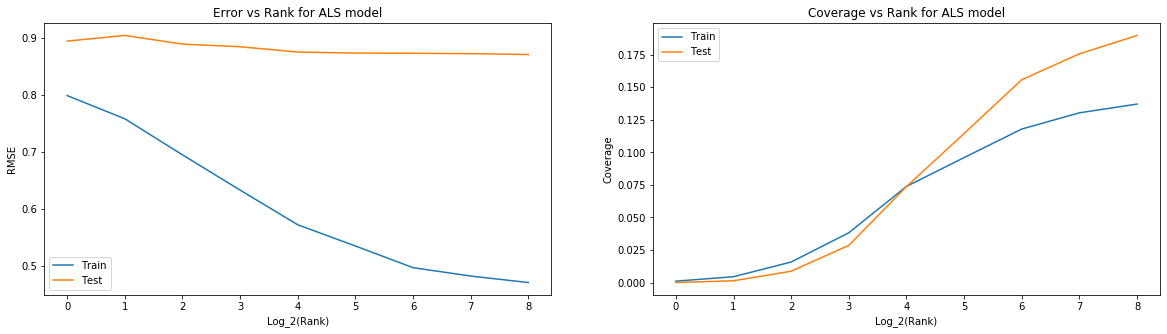

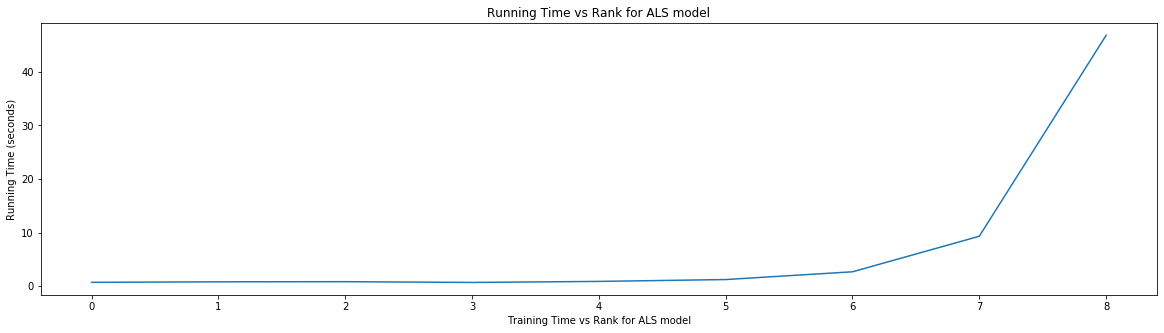

,Rank,RMSE_train,RMSE_test,Coverage_train,Coverage_test,Running_time
0,1.0,0.799520,0.895269,0.001066,0.000000,0.732693
1,2.0,0.758775,0.905170,0.004475,0.001360,0.830213
2,4.0,0.695422,0.889993,0.015770,0.008705,0.854931
3,8.0,0.633468,0.885270,0.038253,0.028564,0.713183
4,16.0,0.572505,0.876050,0.073841,0.073721,0.906533
5,32.0,0.535230,0.874177,0.096004,0.114527,1.252448
6,64.0,0.497137,0.873850,0.117954,0.155876,2.697996
7,128.0,0.482376,0.873182,0.130421,0.175734,9.320667
8,256.0,0.470983,0.871600,0.137134,0.189880,46.763542


In [5]:
pow_two_max_rank = 8

ranks = [2**i for i in range(pow_two_max_rank+1)]

report_df = get_best_rank(ratings_spark_df, ranks=ranks)

plot_performance_als(report_df)
display(report_df)

We observe the following:
1. The training error keeps on decreasing with increased rank, but the test error shows no significant improvement indicating signs of overfitting
2. The coverage of items improves with respect to rank
3. The time to fit the model takes expontially higher time in correlation with rank

Note: We use Catalog Coverage to take into account the number of unique movies that were recommended to atleast one user as a top choice amonsgt the set of all unique movies.

### 2.3 LightFM:

We use LightFM model to find how it performs over over dataset

Performance of LightFm Model 

Precision 	 Train: 0.46 	 Test: 0.18
AUC 		 Train: 0.92 	 Test: 0.87


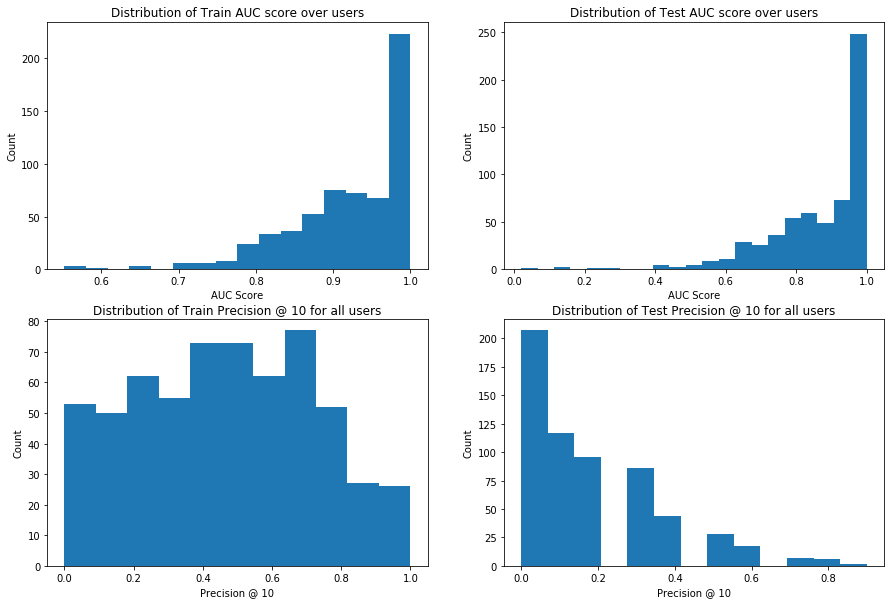

In [6]:
sparse_mat = spark_to_sparse(ratings_spark_df)
lightfm_model(sparse_mat, prec_at_k=10, train_split=0.8)

### 2.4. Neighborhood based method using Nearest Neighbor

We use Nearest Neighbor algorithm with z-score normalization of each user

In [7]:
# Defining parameters for Nearest Neighbor model
sim_options = {'name': 'cosine',
               'user_based': True
               }
model = KNNWithZScore(sim_options=sim_options)

KNN(model=model, df=ratings_spark_df)

Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9008  0.8949  0.9039  0.9016  0.8984  0.8999  0.0031  
MAE (testset)     0.6835  0.6808  0.6854  0.6842  0.6827  0.6833  0.0016  
Fit time          0.26    0.26    0.27    0.28    0.27    0.27    0.01    
Test time         1.28    1.32    1.24    1.26    1.18    1.26    0.05    


#### We observe that the Baseline Bias model performs quite well, and other more sophesiticated models (except lightFM) don't yield significant improvments over it hence the Bias model might be the most suited for production

#### We observe that LightFm model has high AUC, meaning it is producing quantifiably quality results.